# Fit vs Partial fit

Below, we show the use of along with `SGDC1assifier` on a sample data.
For illustration, we first use traditional `fit( )` method and then use on the same data.


In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


## Sample dataset
We will use a synthetic classification dataset for demonstration.\
Let us have 50000 samples with 1O features in the feature matrix. Further, lets have 3 classes in the target label, each class having a single
cluster.


In [ ]:
X,y = make_classification(n_samples = 50000 ,n_features = 10,
                          n_classes = 3, n_clusters_per_class= 1)

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

## Training

Training the data with `SCGClassifier`

In [ ]:
clf = SGDClassifier(max_iter = 1000 , tol = 0.01)

In [ ]:
clf.fit(x_train,y_train)

SGDClassifier(tol=0.01)

## Evaluation

In [ ]:
clf.score(x_train,y_train)

0.8977176470588235

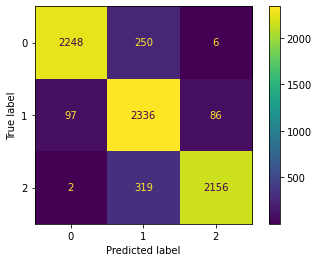

In [ ]:
y_pred = clf.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2504
           1       0.80      0.93      0.86      2519
           2       0.96      0.87      0.91      2477

    accuracy                           0.90      7500
   macro avg       0.91      0.90      0.90      7500
weighted avg       0.91      0.90      0.90      7500



In [ ]:
clf.score(x_test, y_test)

0.8986666666666666

##  Incremental approach using partial fit

We will now assume that the data cannot be kept completely in the main memory and hence, will load chunks of data train them using `partial fit`

In [ ]:
x_train[:5]

array([[-0.99512876,  0.58892363,  0.65828328,  0.72067834,  0.67712262,
         1.59367108, -0.87262729, -0.36778631,  0.56223721, -0.56516055],
       [-0.52313562,  0.45188989,  0.82535197,  0.50467361,  0.0683378 ,
         0.36010723,  0.48013369,  0.02192715,  0.90083879, -1.65818746],
       [-0.72640012, -0.30085693, -0.24086559, -0.4206326 ,  0.46120861,
         0.9045236 , -0.35929885,  1.19924108,  0.84931326,  1.06920557],
       [ 2.28292742,  0.31329964, -0.09312344, -1.33816847,  0.57167279,
         1.17510634, -0.20633859, -0.72455436,  0.88094166,  0.89187385],
       [-0.91074451,  0.63250643, -0.51130377,  0.16686169,  0.27319609,
         0.43900269,  0.70625488,  1.78256236,  1.77863882,  1.41106707]])

In [ ]:
y_train[:5 ]

array([0, 0, 1, 1, 1])

In order to load data chunk by chunk, we will first store the given (training) data in a csv file. (This is just for demonstration purpose. In a real
scenario, the large dataset might already in the form of say, a csv, which we will be reading in multiple iterations.)


In [ ]:
 import numpy as np
 train_data  = np.concatenate((x_train,y_train[:, np.newaxis]), axis =1) # np.newaxis adds new axis

In [ ]:
train_data[:5]

array([[-0.99512876,  0.58892363,  0.65828328,  0.72067834,  0.67712262,
         1.59367108, -0.87262729, -0.36778631,  0.56223721, -0.56516055,
         0.        ],
       [-0.52313562,  0.45188989,  0.82535197,  0.50467361,  0.0683378 ,
         0.36010723,  0.48013369,  0.02192715,  0.90083879, -1.65818746,
         0.        ],
       [-0.72640012, -0.30085693, -0.24086559, -0.4206326 ,  0.46120861,
         0.9045236 , -0.35929885,  1.19924108,  0.84931326,  1.06920557,
         1.        ],
       [ 2.28292742,  0.31329964, -0.09312344, -1.33816847,  0.57167279,
         1.17510634, -0.20633859, -0.72455436,  0.88094166,  0.89187385,
         1.        ],
       [-0.91074451,  0.63250643, -0.51130377,  0.16686169,  0.27319609,
         0.43900269,  0.70625488,  1.78256236,  1.77863882,  1.41106707,
         1.        ]])

In [ ]:
a = np.asarray(train_data)
np.savetxt('train_data.csv', a, delimiter = ',')

Lets create `SGDClassifier model` that we intend to `partial_fit()`

In [ ]:
clf2 = SGDClassifier(max_iter = 1000, tol = 0.01)

##Processing data chunk by chunk
Pandas `read_csv()` function has an attributre chunksize that can be used to read data chunk by chunk. The chunksize parameter specifies
the number of rows per chunk. (The last chunk may contain fewer than chunksize rows, of course.)\
We can then use this data for `partial _ fit` . We can then repeat these two steps multiple times. That way, entire data may not be reqiuired to
be kept in memory.


In [ ]:
import pandas as pd

chunksize = 1000

iter = 1
for train_df in pd.read_csv('train_data.csv', chunksize = chunksize , iterator = True ):

  if iter == 1:
    x_train_partial = train_df.iloc[:, :10]
    y_train_partial = train_df.iloc[:,10]
    clf2.partial_fit(x_train_partial, y_train_partial,
                     classes =np.array([0, 1, 2]))
  else:
    x_train_partial = train_df.iloc[:, :10]
    y_train_partial = train_df.iloc[:,10]
    clf2.partial_fit(x_train_partial, y_train_partial)
  
  print('After iter #',iter)
  print(clf2.coef_)
  print(clf2.intercept_)
  iter = iter  + 1

**Notes:**
* In the first call to partial _ fit( ) , we passed the list of possible target class labels. For subsequent calls to , this is not
required.
* Observe the changing values pf the classifier attributes: `coef_` and `intercept_` which we are printing in each iteration.


In [ ]:
test_score = clf2.score(x_test, y_test)
print(test_score)

0.8514666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


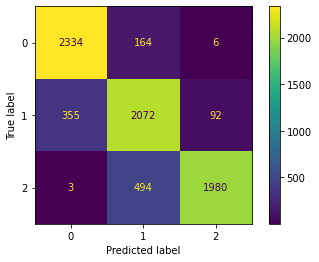

In [ ]:
y_pred = clf2.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2504
           1       0.76      0.82      0.79      2519
           2       0.95      0.80      0.87      2477

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500



#Incremental Preprocessing Example




##`Countvectorize`r VS `Hashingvectorizer`

Vectorizers are used to convert a collection of text documents to a vector representation, thus helping in preprocessing them before applying
any model on these text documents.

`countvectorizer` and `Hashingvectorizer` both perform the task of vectorizing the text documents. However, there are some differences
among them.

One difference is that Hashingvectorizer does not store the resulting (i.e. the unique tokens). Hence, it can be used to learn from
data that does not fit into the computer's main memory. Each mini-batch is vectorized using Hashingvectorizer so as to guarantee that the
input spacæ of the estimator has always the same dimensionality.

With Hashingvectorizer , each token directly maps to a pre-defined column position in a matrix. For example, if there are 100 columns in the
resultant (vectorized) matrix, each token (word) maps to 1 Of the 100 columns. The mapping between the word and the in matrix is
done using hashing.

In other words, in Hashingvectorizer , each token transforms to a column position instead of adding to the vocabulary. Not storing the
vocabulary is useful while handling large data sets. This is because holding a huge token vocabulary comprising of millions of words may be a
challenege when the memory is limited.

Since Hashingvectorizer does not store vocabulary, its object not only takes lesser space, it also alleviates any dependence with function
calls performed on the previous chunk Of data in case Of incremental learning.


## Example

In [ ]:
text_documents = ['The well-known saying an apple a day keeps the doctor away has a very straightforward, literal meaning, that the eating of fruit maintains good health.',
                  'The proverb fist appeared in print in 1866 and over 150 years later is advice that we still pass down through generation.',
                  'British apples are one of the nations best loved fruit and according to Great British Apples, we consume around 122,000 tonnes of them each year.',
                  'But what are the health benefits, and do they really keep the doctor away?']

### 1. Countvectorizer
We will first import the library and then create an object of CountVectorizer class.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
c_vect = CountVectorizer()

In [ ]:
X_c = c_vect.fit_transform(text_documents)

In [ ]:
X_c.shape

(4, 66)

Here, 66 is the size of the vocabulary.

We can also see the vocabulary using `vocabulary_` attribute.

In [ ]:
c_vect.vocabulary_

{'000': 0,
 '122': 1,
 '150': 2,
 '1866': 3,
 'according': 4,
 'advice': 5,
 'an': 6,
 'and': 7,
 'appeared': 8,
 'apple': 9,
 'apples': 10,
 'are': 11,
 'around': 12,
 'away': 13,
 'benefits': 14,
 'best': 15,
 'british': 16,
 'but': 17,
 'consume': 18,
 'day': 19,
 'do': 20,
 'doctor': 21,
 'down': 22,
 'each': 23,
 'eating': 24,
 'fist': 25,
 'fruit': 26,
 'generation': 27,
 'good': 28,
 'great': 29,
 'has': 30,
 'health': 31,
 'in': 32,
 'is': 33,
 'keep': 34,
 'keeps': 35,
 'known': 36,
 'later': 37,
 'literal': 38,
 'loved': 39,
 'maintains': 40,
 'meaning': 41,
 'nations': 42,
 'of': 43,
 'one': 44,
 'over': 45,
 'pass': 46,
 'print': 47,
 'proverb': 48,
 'really': 49,
 'saying': 50,
 'still': 51,
 'straightforward': 52,
 'that': 53,
 'the': 54,
 'them': 55,
 'they': 56,
 'through': 57,
 'to': 58,
 'tonnes': 59,
 'very': 60,
 'we': 61,
 'well': 62,
 'what': 63,
 'year': 64,
 'years': 65}

In [ ]:
print(X_c)

  (0, 54)	3
  (0, 62)	1
  (0, 36)	1
  (0, 50)	1
  (0, 6)	1
  (0, 9)	1
  (0, 19)	1
  (0, 35)	1
  (0, 21)	1
  (0, 13)	1
  (0, 30)	1
  (0, 60)	1
  (0, 52)	1
  (0, 38)	1
  (0, 41)	1
  (0, 53)	1
  (0, 24)	1
  (0, 43)	1
  (0, 26)	1
  (0, 40)	1
  (0, 28)	1
  (0, 31)	1
  (1, 54)	1
  (1, 53)	1
  (1, 48)	1
  :	:
  (2, 39)	1
  (2, 4)	1
  (2, 58)	1
  (2, 29)	1
  (2, 18)	1
  (2, 12)	1
  (2, 1)	1
  (2, 0)	1
  (2, 59)	1
  (2, 55)	1
  (2, 23)	1
  (2, 64)	1
  (3, 54)	2
  (3, 21)	1
  (3, 13)	1
  (3, 31)	1
  (3, 7)	1
  (3, 11)	1
  (3, 17)	1
  (3, 63)	1
  (3, 14)	1
  (3, 20)	1
  (3, 56)	1
  (3, 49)	1
  (3, 34)	1


### ` HashingVectorizer`

Let us create an object of `HashingVectorizer` class. An important parameter of this class is `n_features`. It declares the number of features (columns) in the output feature matrix.

Note: Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
h_vec = HashingVectorizer(n_features = 50)
X_h = h_vec.fit_transform(text_documents)

In [ ]:
X_h.shape


(4, 50)

In [ ]:
print(X_h[0])

  (0, 5)	0.0
  (0, 8)	-0.47140452079103173
  (0, 10)	-0.23570226039551587
  (0, 11)	-0.23570226039551587
  (0, 13)	0.0
  (0, 18)	-0.23570226039551587
  (0, 20)	0.23570226039551587
  (0, 26)	0.0
  (0, 29)	0.23570226039551587
  (0, 33)	0.23570226039551587
  (0, 36)	-0.23570226039551587
  (0, 38)	0.47140452079103173
  (0, 39)	-0.23570226039551587
  (0, 45)	-0.23570226039551587
  (0, 46)	0.23570226039551587


Overall, `HashingVectorizer` is a good choice if we are falling short of memory and resources, or we need to perform incremental learning.
 However, `CountVectorizer` is a good choice if we need to access the actual tokens.


# Sentiment Analysis Using Realworld Data

## 1. Downloading the dataset




Below, we download a dataset from UCI ML datasets's library.(Instead of downloading, unzipping and then reading, we are directly reading the zipped csv file. For that purpose, we are making use of `urllib.request`, `BytesIO` and `TextIOWrapper` classes)


This is a sentiment analysis dataset. There are only two columns in the dataset. One for the textual review and the other for the sentiment.

In [ ]:
import pandas as pd 
from io import StringIO, BytesIO, TextIOWrapper 
from zipfile import ZipFile 
import urllib.request

resp = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip')
zipfile = ZipFile(BytesIO(resp.read()))

data = TextIOWrapper(zipfile.open('sentiment labelled sentences/amazon_cells_labelled.txt'),encoding='utf-8') 

df = pd.read_csv(data, sep='\t') 
df.columns = ['review', 'sentiment']

## 2. Exploring the dataset
Let's explore the dataset a bit.


In [ ]:
df.head()

,review,sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [ ]:
df.tail()

,review,sentiment
994,The screen does get smudged easily because it ...,0
995,What a piece of junk.. I lose more calls on th...,0
996,Item Does Not Match Picture.,0
997,The only thing that disappoint me is the infra...,0
998,"You can not answer calls with the unit, never ...",0


In [ ]:
df.describe()

,sentiment
count,999.000000
mean,0.500501
std,0.500250
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     999 non-null    object
 1   sentiment  999 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


As we can see, 
* There are 999 samples in the dataset.
* The possible classes for sentiment are 1 and 0.


## 3. Spliting data into train and test

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X = df.loc[:,'review']
y = df.loc[:,'sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [ ]:
x_train.shape

(799,)

In [ ]:
y_train.shape

(799,)

#4. Preprocessing 

Since the data is textual, we need to vectorize it. In order to perform incremental learning, we will use `HashingVectorizer`. 

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
h_vec = HashingVectorizer()

## 5. Creating an instance of SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
classifier  = SGDClassifier(penalty = 'l2', loss = 'hinge')

#6. Iteration 1 of partial_fit() 

We will assume we do not have sufficient memory to handle all the 799 samples in one go for training purpose. So, we will take the first 400 samples from the training data and `partial_fit()` our classifier.


Another use case of partial_fit here could also be a scenario where we only have 400 samples available at a time. So, we fit our classifier with them. However, we `partial_fit` it, to have the possibility of traning it with more data later whenever that becomes available.


In [ ]:
x_train_hashed_1 = h_vec.fit_transform(x_train[:400])
y_train_1 = y_train[:400]


In [ ]:
all_classes = np.unique(df.loc[:,'sentiment'])

In [ ]:
all_classes

array([0, 1])

In [ ]:
classifier.partial_fit(x_train_hashed_1, y_train_1, classes = all_classes)

SGDClassifier()

In [ ]:
classifier.score(x_train_hashed_1,y_train_1)

0.8275

In [ ]:
x_test_hashed = h_vec.fit_transform(x_test)

In [ ]:
classifier.score(x_test_hashed,y_test)

0.71

Note: We can also store this classifier using pickle object and can access it later.



#7. Iteration 2 of partial_fit()

We will now assume that more data became available. So, we will fit the same  classifier with more data and observe if our test score improves.

In [ ]:
x_train_hashed_2 = h_vec.fit_transform(x_train[400:])
y_train_2 = y_train[400:]

In [ ]:
classifier.fit(x_train_hashed_2,y_train_2)

SGDClassifier()

In [ ]:
classifier.score(x_test_hashed,y_test)

0.77